<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainPhaseClassifier_05_Keras_first_6_pages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [33]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [34]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 6 pages because of memory constraints
    if len(pages) > 6:
      pages = pages[:6]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [35]:
df_annotations = df_annotations[~df_annotations.phase.isna()]

In [36]:
df_annotations["phase"].value_counts()

Phase 2            4317
Phase 3            2725
Phase 4            1461
Phase 1            1154
Phase 1/Phase 2     983
Not Applicable      519
Phase 2/Phase 3     297
Early Phase 1       135
Name: phase, dtype: int64

In [37]:
df_annotations["phase"].value_counts().max() / df_annotations["phase"].value_counts()

Phase 2             1.000000
Phase 3             1.584220
Phase 4             2.954825
Phase 1             3.740901
Phase 1/Phase 2     4.391658
Not Applicable      8.317919
Phase 2/Phase 3    14.535354
Early Phase 1      31.977778
Name: phase, dtype: float64

In [58]:
labels = sorted(set(df_annotations["phase"]))

In [68]:
labels

['Early Phase 1',
 'Not Applicable',
 'Phase 1',
 'Phase 1/Phase 2',
 'Phase 2',
 'Phase 2/Phase 3',
 'Phase 3',
 'Phase 4']

In [59]:
num_classes = len(labels)

In [60]:
label_to_idx = {}
for idx, label in enumerate(labels):
  label_to_idx[label] = idx

In [61]:
def to_one_hot(phase):
  a = [0] * len(labels)
  a[label_to_idx[phase]] = 1
  return np.asarray(a)

In [62]:
phase

'Phase 3'

In [63]:
train_labels = []
train_examples = []
test_labels = []
test_examples = []

for idx in range(len(df_annotations)):
  
  if df_annotations.train_val.iloc[idx] == "train":
    these_labels = train_labels
    examples = train_examples
  else:
    these_labels = test_labels
    examples = test_examples
  
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]

  phase = df_annotations.phase.iloc[idx]

  # data augmenting
  aug = 1
  if  df_annotations.train_val.iloc[idx] == "train" and phase not in ("Phase 2", "Phase 3", "Phase 4",  ):
    aug = 2
  for i in range(aug):
    these_labels.append(to_one_hot(phase))
    examples.append(text)

In [64]:
c = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [65]:
train_examples = np.asarray(train_examples)
test_examples = np.asarray(test_examples)

# Begin Keras

In [69]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [70]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])


<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 1.4520766 ,  0.14392681,  1.0241674 ,  0.2082952 ,  1.7013401 ,
        -1.8502012 , -1.7247353 ,  0.59570205,  0.12547296, -0.09221198,
         0.25371724, -0.75667506, -0.18044491, -1.1822199 ,  1.0065392 ,
         0.66017145,  3.0587838 , -1.6261206 ,  0.06929344,  1.8323723 ,
         0.4978937 ,  0.3285482 ,  0.7654918 , -1.2233241 , -0.1807414 ,
        -3.205798  ,  1.552178  ,  1.9313946 , -0.8581004 , -0.4258135 ,
         0.7067108 ,  1.2935582 , -2.8316429 ,  0.088562  ,  1.8663073 ,
        -1.5251645 ,  1.226979  , -0.10428789, -0.72332424,  1.1969528 ,
        -0.07133699, -0.6894014 ,  0.47003335,  0.02840734, -0.8264981 ,
         0.49195358, -0.271986  ,  0.6488113 , -0.72584236,  1.3634989 ],
       [ 3.7083087 , -0.241776  ,  0.6364168 ,  0.7943938 ,  1.9948822 ,
        -1.3595589 , -1.6440583 ,  1.0520076 , -0.08786397,  0.7368886 ,
        -0.59569865, -0.2995656 ,  0.12506673, -0.9447105 ,  1.0842537 ,
 

In [71]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
Total params: 48,191,552
Trainable params: 48,191,552
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=[tf.metrics.CategoricalCrossentropy(name='accuracy'), tf.metrics.AUC(name='auc')],
              run_eagerly=True)


In [74]:
partial_x_train = train_examples
x_val = test_examples

partial_y_train = train_labels
y_val = test_labels

In [75]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
23/23 [==============================] - 5s 152ms/step - loss: 2.0870 - accuracy: 2.0870 - auc: 0.6224 - val_loss: 1.8105 - val_accuracy: 1.8105 - val_auc: 0.7445
Epoch 2/20
23/23 [==============================] - 3s 149ms/step - loss: 1.8079 - accuracy: 1.8079 - auc: 0.7418 - val_loss: 1.6685 - val_accuracy: 1.6685 - val_auc: 0.7981
Epoch 3/20
23/23 [==============================] - 3s 152ms/step - loss: 1.6629 - accuracy: 1.6629 - auc: 0.7959 - val_loss: 1.6042 - val_accuracy: 1.6042 - val_auc: 0.8158
Epoch 4/20
23/23 [==============================] - 3s 147ms/step - loss: 1.5334 - accuracy: 1.5334 - auc: 0.8337 - val_loss: 1.5351 - val_accuracy: 1.5351 - val_auc: 0.8317
Epoch 5/20
23/23 [==============================] - 3s 147ms/step - loss: 1.4048 - accuracy: 1.4048 - auc: 0.8656 - val_loss: 1.4786 - val_accuracy: 1.4786 - val_auc: 0.8428
Epoch 6/20
23/23 [==============================] - 3s 149ms/step - loss: 1.2756 - accuracy: 1.2756 - auc: 0.8917 - val_loss: 1.43

In [76]:
model.save('/content/drive/MyDrive/data/phase_model_05.keras')

In [77]:
results = model.evaluate(test_examples, test_labels)

print(results)

73/73 [==============================] - 2s 21ms/step - loss: 1.5402 - accuracy: 1.5402 - auc: 0.8602
[1.5401532649993896, 1.5401532649993896, 0.8601692318916321]


In [78]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

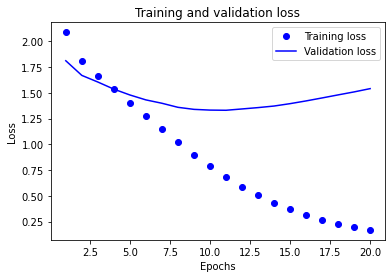

In [79]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

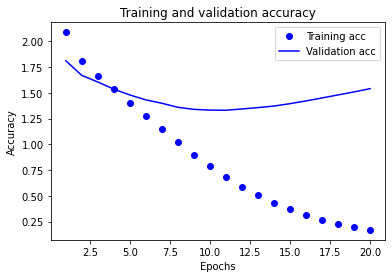

In [80]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [81]:
df_val = df_annotations[df_annotations.train_val=="val"]
input_texts= np.asarray(df_val.text)

In [84]:
y_pred_proba = model.predict(input_texts)

34/34 [==============================] - 0s 8ms/step


In [85]:
y_pred_proba

array([[4.9108558e-04, 2.4206705e-04, 8.1899787e-05, ..., 6.5262377e-04,
        6.3902909e-01, 6.9443677e-03],
       [1.4934693e-03, 2.7765112e-04, 7.3560677e-02, ..., 6.7549967e-03,
        1.1171228e-01, 2.7269730e-02],
       [2.4850950e-02, 2.1409929e-02, 9.0969112e-03, ..., 3.8018811e-02,
        1.4255507e-01, 9.0467587e-02],
       ...,
       [1.0136728e-02, 3.7712145e-01, 3.8929011e-05, ..., 3.1596683e-02,
        5.6994777e-02, 5.2029073e-01],
       [2.6122993e-03, 7.3664455e-04, 3.8163183e-04, ..., 7.6937996e-04,
        5.9300015e-04, 3.9909116e-04],
       [1.3331895e-03, 8.1891278e-03, 7.8212857e-01, ..., 7.5160027e-02,
        2.5188923e-02, 2.5522897e-02]], dtype=float32)

In [88]:
df_val["y_pred_phase"] = [labels[int(np.argmax(x))] for x in y_pred_proba]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
df_val["y_pred_phase"]

12               Phase 3
49               Phase 2
50               Phase 2
51               Phase 3
52               Phase 2
              ...       
11903            Phase 2
11904    Phase 2/Phase 3
11905            Phase 4
11906            Phase 2
11907            Phase 1
Name: y_pred_phase, Length: 1057, dtype: object

In [90]:
pred_phase = df_val["y_pred_phase"]

In [91]:
acc = accuracy_score(df_val.phase, df_val["y_pred_phase"])
print (f"Phase accuracy {acc}")

Phase accuracy 0.533585619678335


''

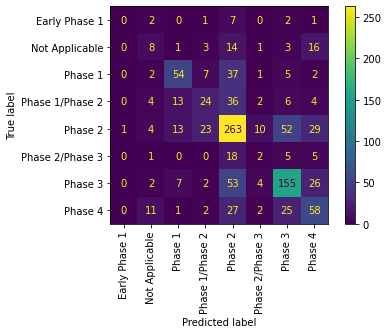

In [92]:
ConfusionMatrixDisplay.from_predictions(df_val.phase, df_val["y_pred_phase"])
plt.xticks(rotation=90)
;

In [28]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for phase in labels:
  roc_auc = roc_auc_score(df_val.phase == phase, [p[phase] for p in predictions])
  print (f"Phase ROC AUC {roc_auc} for {phase}")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

Phase ROC AUC 0.6317418213969939 for Early Phase 1
Phase ROC AUC 0.7959833139809918 for Not Applicable
Phase ROC AUC 0.8760439839206962 for Phase 1
Phase ROC AUC 0.7666624106230848 for Phase 1/Phase 2
Phase ROC AUC 0.7668323836475582 for Phase 2
Phase ROC AUC 0.700685405269446 for Phase 2/Phase 3
Phase ROC AUC 0.8337558153405703 for Phase 3
Phase ROC AUC 0.8360186179735053 for Phase 4
Average 0.7759654690191058


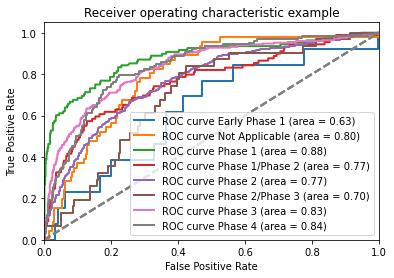

In [29]:
plt.figure()
lw = 2
    
for phase in labels:
    fpr, tpr, _ = roc_curve(df_val.phase == phase, [p[phase] for p in predictions])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve {phase} (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()